In [1]:
import sys
import os
import pickle
from scipy import sparse
import scanpy as sc
import anndata as ad
from anndata import AnnData
import scvi
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn

from perturbnet.util import * 
from perturbnet.cinn.flow import * 
from perturbnet.chemicalvae.chemicalVAE import *
from perturbnet.data_vae.vae import *
from perturbnet.cinn.flow_generate import TFVAEZ_CheckNet2Net, SCVIZ_CheckNet2Net


%load_ext autoreload
%autoreload 2
%matplotlib inline
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#  Example data and preprocssing

1. Exmaple datasets are the subset of dataset from LINCS-Drug dataset(GSE92742) and sci-Plex dataset(GSM4150378). Because LINCS-Drug dataset is normalized and only contains landmark genes, we don't apply the following preprocessing step to LINCS-Drug.

2. The preprocessing mainly follows the scanpy's pipeline. including:  
```
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=5, min_disp=0.5)
```

3. All highly variable genes are seleceted for the model training and down stream analyis

4. Differentially expressed genes are calculated using:

```
# your treatment columns in the adata.obs
groups = "treatment"
# your reference level treatment
control = "S0000"
sc.tl.rank_genes_groups(adata, n_genes = 50, method = "t-test", corr_method = "benjamini-hochberg",groupby = groups,
 reference = control)
```

In [2]:
adata_lincs = ad.read_h5ad("./../example_data/lincs_example.h5ad")
adata_sciplex = ad.read_h5ad("./../example_data/sciplex_example.h5ad")

# Convert SMILES to one-hot matrix
1. To use the pretrained ChemicalVAE, you need to convert your chemicals (represented in SMILES format) into a one-hot matrix. The one-hot matrix size must be 120×35. Therefore, any SMILES string longer than 120 characters or containing characters outside of the provided list should be excluded. The character list is shown below:   
```
char_list = ["7", "6", "o", "]", "3", "s", "(", "-", "S", "/", "B", "4", "[", ")", "#", "I", "l", "O", "H", "c", "1", "@", "=", "n", "P", "8", "C", "2", "F", "5", "r", "N", "+", "\\", " "]
```
2. Save your treatment and corresponding one-hot matrix in the samr order in the adata.uns
3.  LINCS dataset has its all treatment in  ```adata.uns["ordered_all_smile"]``` and their corresponding one-hot matrix are stored in ```adata.uns["ordered_all_onehot"]```
4. Sciplex dataset has its all treatment in  ```adata.uns["ordered_all_smile_chemvae"]``` and their corresponding one-hot matrix are stored in ```adata.uns["ordered_all_onehot_chemvae"]```


In [14]:
good_smile = ['c1ccc2c(CCNc3ccc(Nc4ccncc4)cc3)c[nH]c2c1',
       'CC(=O)Nc1ccc(C(=O)Nc2ccccc2N)cc1',
       'CC(=O)Nc1ccc(OCC(C)(O)C(=O)Nc2ccc([N+](=O)[O-])c(C(F)(F)F)c2)cc1',
       'CC(C)(CNC(=O)c1cccc(-c2noc(C(F)(F)F)n2)c1)c1coc(-c2ccccc2)n1',
       'Cc1nnc(C(C)C)n1C1CC2CCC(C1)N2CCC(NC(=O)C1CCC(F)(F)CC1)c1ccccc1']

In [17]:
onehot = smiles_to_hot(smiles =good_smile, max_len = 120, padding = "right",  nchars = 35)

5it [00:00, 25085.55it/s]


In [20]:
adata_sciplex.uns["ordered_all_smile_example"]  = good_smile
adata_sciplex.uns["ordered_all_onehot_example"]  = onehot

# Create train-test splits
Add new splits to the anndata. The function will include the control cells in the training split. In this toy dataset, we don't have a control category, so we use the first treatment as the control. You can pass a list of controls if you have multiple treatments that need to be arbitrarily included in the training split.

In [4]:
example_control = adata_lincs.obs.perturb_string[0]
example_control

'ONC(=O)CCCCCCC(=O)Nc1ccccc1'

In [5]:
create_train_test_splits_by_key(adata_lincs,train_ratio = 0.8, add_key = "split_example", split_key = "perturb_string", 
                                control = [example_control]
                                , random_seed=42)

In [6]:
adata_lincs

AnnData object with n_obs × n_vars = 30568 × 978
    obs: 'index', 'cell', 'inst_id', 'pert_id', 'pert_iname', 'pert_type', 'is_touchstone', 'inchi_key_prefix', 'inchi_key', 'canonical_smiles', 'perturb_string', 'cell_types ', 'fake_dose', 'if_remove', 'if_has_isoform', 'rna_plate', 'rna_well', 'pert_time', 'pert_time_unit', 'batch_ident', 'cell_id', 'perturb_string_chemvae_flag', 'chem_iso_saved_flag', 'holdout1', 'holdout2', 'holdout3', 'holdout4', 'holdout5', 'Kmeans30', 'split_example'
    uns: 'ordered_all_onehot', 'ordered_all_smile'
    obsm: 'cellstates', 'umap_z'

In [7]:
example_control = adata_sciplex.obs.perturb_string[0]
example_control

'CCS(=O)(=O)c1cccc(-c2cc(C(=O)NC3CCN(C)CC3)c(C)c3[nH]c4ncc(C)cc4c23)c1'

In [8]:
create_train_test_splits_by_key(adata_sciplex,train_ratio = 0.8, add_key = "split_example", split_key = "perturb_string_processed", 
                                control = [example_control]
                                , random_seed=42)

# Train cellular Representation Network

1. Regular VAE for the normalzied expression data and scVI for the raw count expression data

In [3]:
# note the lincs data is normalized, the data matrix is not sparse
lincs_train = adata_lincs[adata_lincs.obs["split_example"] == "train"].X
lincs_test= adata_lincs[adata_lincs.obs["split_example"] == "test"].X

In [ ]:
# Regular VAE on the Lincs Dataset, we reduce the n_epochs for the example dataset.We used n_epochs = 151 for the whole dataset
# provide an unexisting directory for saving
vae = VAE(num_cells_train = lincs_train .shape[0], x_dimension = lincs_train .shape[1], learning_rate = 1e-4, BNTrainingMode = False)
vae.train_np(train_data = lincs_train ,use_validation = True,valid_data =lincs_test,
             n_epochs = 81, save = True, model_save_path = "./lincs_example/cellvae",verbose = False)

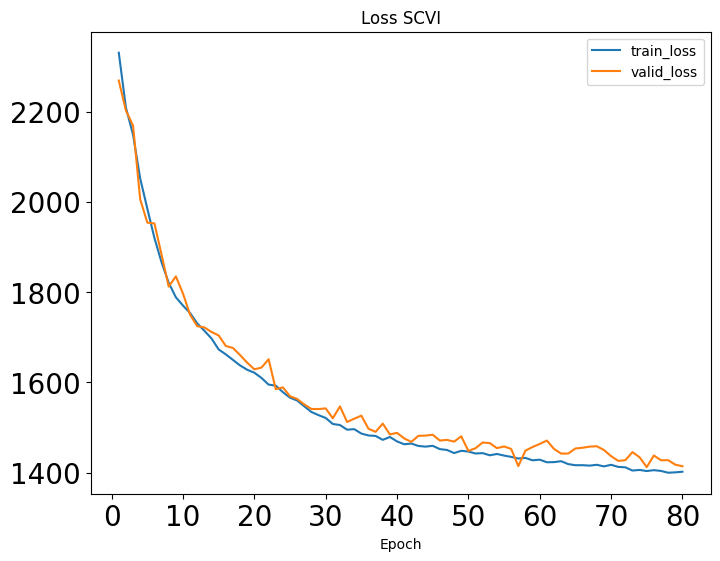

In [12]:
train_loss = np.array(vae.train_loss)
valid_loss = np.array(vae.valid_loss)
trainvalid_loss = np.concatenate([train_loss.reshape([train_loss.shape[0], 1]), 
									  valid_loss.reshape([valid_loss.shape[0], 1])], axis = 1)
trainvalid_loss_pd = pd.DataFrame(trainvalid_loss)
trainvalid_loss_pd.columns = ['train_loss', 'valid_loss']
trainvalid_loss_pd['Epoch'] = np.arange(train_loss.shape[0])
newfig = trainvalid_loss_pd.iloc[1:,].set_index('Epoch').plot(figsize = [8,6 ], fontsize = 20).get_figure()
plt.title("Loss SCVI")
plt.show()

In [ ]:
# load vae model
vae = VAE(num_cells_train = lincs_train .shape[0], x_dimension = lincs_train .shape[1], learning_rate = 1e-4, BNTrainingMode = False)
vae.restore_model(tf.train.latest_checkpoint("./lincs_example/cellvae"))

**Note: To use PerturbNet with Python 3.10, you should load your vae as follows:**

In [ ]:
vae = VAE(num_cells_train = lincs_train .shape[0], x_dimension = lincs_train .shape[1], learning_rate = 1e-4, BNTrainingMode = False)
vae.restore_model("./lincs_example/cellvae/model_epoch_81.pt")

**scVI for raw count data on sciplex**  
When training the scVI model, 700 epoches are recommended. The KL warmup requires for 400 epochs. Here we used only 420 epochs to avoid overfitting on the toy dataset

In [5]:
adata_train_sciplex = adata_sciplex[adata_sciplex.obs.split_example == "train",:].copy()
adata_test_sciplex = adata_sciplex[adata_sciplex.obs.split_example == "test",:].copy()

In [15]:

# provide an unexisting directory for saving

scvi_model_save_path = "./sciplex_example/cellvae/"
scvi.data.setup_anndata(adata_train_sciplex , layer = "counts")
scvi_model = scvi.model.SCVI(adata_train_sciplex, n_latent = 10)
scvi_model.train(n_epochs = 420,frequency = 20)
scvi_model.save(scvi_model_save_path )

INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.layers["counts"]                                                                    
INFO     Computing library size prior per batch                                                                    
INFO     Successfully registered anndata object containing 25000 cells, 5087 vars, 1 batches, 1 labels, and 0      
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                
INFO     Training for 420 epochs                                                                                   
INFO     KL warmup for 400 epochs                                       

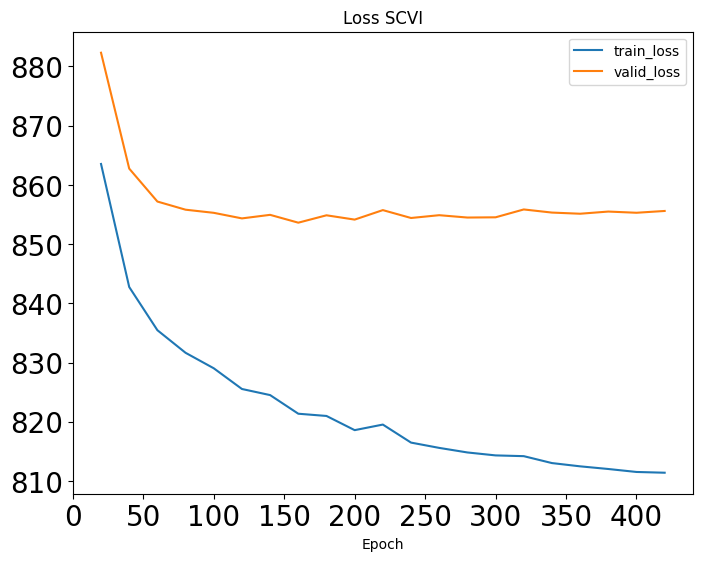

In [16]:
%matplotlib inline
train_loss = np.array(scvi_model.history["elbo_train_set"])
valid_loss = np.array(scvi_model.history["elbo_test_set"])
trainvalid_loss = np.concatenate([train_loss.reshape([train_loss.shape[0], 1]), 
									  valid_loss.reshape([valid_loss.shape[0], 1])], axis = 1)
trainvalid_loss_pd = pd.DataFrame(trainvalid_loss)
trainvalid_loss_pd.columns = ['train_loss', 'valid_loss']
trainvalid_loss_pd['Epoch'] = np.arange(train_loss.shape[0]) * 20
newfig = trainvalid_loss_pd.iloc[1:,].set_index('Epoch').plot(figsize = [8,6 ], fontsize = 20).get_figure()
plt.title("Loss SCVI")
plt.show()

In [8]:
# load_scvi_model
scvi.data.setup_anndata(adata_train_sciplex, layer = "counts")
scvi_model = scvi.model.SCVI.load(scvi_model_save_path, adata_train_sciplex, use_cuda = False)

INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.layers["counts"]                                                                    
INFO     Computing library size prior per batch                                                                    
INFO     Successfully registered anndata object containing 25000 cells, 5087 vars, 1 batches, 1 labels, and 0      
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                
INFO     Using data from adata.layers["counts"]                                                                    
INFO     Computing library size prior per batch                         

# Train cinn model 
1. load the chemicalVAE for perturbation representation
2. build the std model to standardize the chemical representation
3. create the input embeddings and build the cinn

In [ ]:
zinc_onehot = np.load("./../pretrained_model/chemicalVAE/onehot_zinc.npy")
path_chemvae_model = "./../pretrained_model/chemicalVAE/model_params_525.pt"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_chemvae = ChemicalVAE(n_char = zinc_onehot.shape[2],  max_len = zinc_onehot.shape[1]).to(device)
model_chemvae.load_state_dict(torch.load(path_chemvae_model, map_location = device))
model_chemvae.eval()

In [57]:
std_model = Standardize(data_all = zinc_onehot, model = model_chemvae, device = device)

In [59]:
# save parameters
np.save("./../pretrained_model/chemicalVAE/mu.npy",std_model.mu)
np.save("./../pretrained_model/chemicalVAE/std.npy",std_model.std)

In [10]:
# load std model
path_std_param = "./../pretrained_model/chemicalVAE/"
mu_std_model = np.load(os.path.join(path_std_param, "mu.npy"))
std_std_model = np.load(os.path.join(path_std_param, "std.npy"))
std_model = StandardizeLoad(mu_std_model, std_std_model, device)


In [11]:
adata_train_lincs = adata_lincs[adata_lincs.obs.split_example == "train",:].copy()
adata_test_lincs = adata_lincs[adata_lincs.obs.split_example == "test",:].copy()

In [12]:

cond_stage_data_lincs, embeddings_lincs, perturbToEmbed_lincs= prepare_embeddings_cinn(adata_train_lincs,
                                                                                       perturbation_key = "perturb_string", 
                                                                                       trt_key = "ordered_all_smile", 
                                                                                       embed_key = "ordered_all_onehot")
cond_stage_data_sciplex, embeddings_sciplex, perturbToEmbed_sciplex = prepare_embeddings_cinn(adata_train_sciplex,  
                                                                                              perturbation_key = "perturb_string_processed",
                                                                                              trt_key = "ordered_all_smile_chemvae", 
                                                                                              embed_key = "ordered_all_onehot_chemvae")

# Unadjusted cinn on LINCS-Drug
1.  Make sure to check the loss when you have different data. In our setting, the model usually converges between 50 and 100 epochs.

**build cinn model with customized parameters**
1. conditional_dim: dimension of perturbation latent embeddings
2. embedding_dim: dimension of latent cell embeddings
3. conditioning_depth: number of the layers for conditioanl information input(perturbation latent embeddings)
4. n_flows: number of the flow blocks
5. hidden_dim: dimension of the hidden layers
6. hidden_depth: number of the hidden layers in the flow blocks

In [26]:
path_cinn_model_save = "./lincs_example/cinn/"
torch.manual_seed(42)
flow_model_lincs = ConditionalFlatCouplingFlow(   conditioning_dim = 196, # dimension of your perturbation embeddings
                                            embedding_dim = 10, # dimension of your cell states embeddings
                                            conditioning_depth = 2, 
                                            n_flows = 20, # number of flow blocks
                                            in_channels = 10, 
                                            hidden_dim = 1024, 
                                            hidden_depth = 2, 
                                            activation = "none", 
                                            conditioner_use_bn = True)

model_c_lincs = Net2NetFlow_TFVAEFlow(  configured_flow = flow_model_lincs,
                                        first_stage_data = lincs_train,
                                        cond_stage_data = cond_stage_data_lincs,
                                        perturbToOnehotLib = perturbToEmbed_lincs,
                                        oneHotData = embeddings_lincs, 
                                        model_con = model_chemvae, 
                                        std_model = std_model, 
                                        sess = vae.sess, 
                                        enc_ph = vae.x, 
                                        z_gen_data_v = vae.z_mean, 
                                        is_training = vae.is_training)
model_c_lincs.to(device = device)
model_c_lincs.train_cinn(n_epochs = 50, batch_size = 128, lr = 4.5e-6, auto_save = 10,auto_save_path = path_cinn_model_save + "Auto/")
model_c_lincs.save(path_cinn_model_save + "50ep/")

Note: Conditioning network uses batch-normalization. Make sure to train with a sufficiently large batch size
[Epoch 1/50] [Batch 39/39] [loss: 4.984988/2.875571]
[Epoch 2/50] [Batch 39/39] [loss: 2.151786/1.517588]
[Epoch 3/50] [Batch 39/39] [loss: 1.088992/0.691474]
[Epoch 4/50] [Batch 39/39] [loss: 0.407900/0.215897]
[Epoch 5/50] [Batch 39/39] [loss: -0.090157/-0.274080]
[Epoch 6/50] [Batch 39/39] [loss: -0.496206/-0.574196]
[Epoch 7/50] [Batch 39/39] [loss: -0.826168/-0.883113]
[Epoch 8/50] [Batch 39/39] [loss: -1.083929/-1.169715]
[Epoch 9/50] [Batch 39/39] [loss: -1.325734/-1.310077]
[Epoch 10/50] [Batch 39/39] [loss: -1.507252/-1.458980]
[Epoch 11/50] [Batch 39/39] [loss: -1.680365/-1.611901]
[Epoch 12/50] [Batch 39/39] [loss: -1.821514/-1.744434]
[Epoch 13/50] [Batch 39/39] [loss: -1.953487/-1.832516]
[Epoch 14/50] [Batch 39/39] [loss: -2.079158/-1.856538]
[Epoch 15/50] [Batch 39/39] [loss: -2.191886/-1.958175]
[Epoch 16/50] [Batch 39/39] [loss: -2.268731/-2.062045]
[Epoch 17/50

Text(0.5, 1.0, 'Minutes: 23.4')

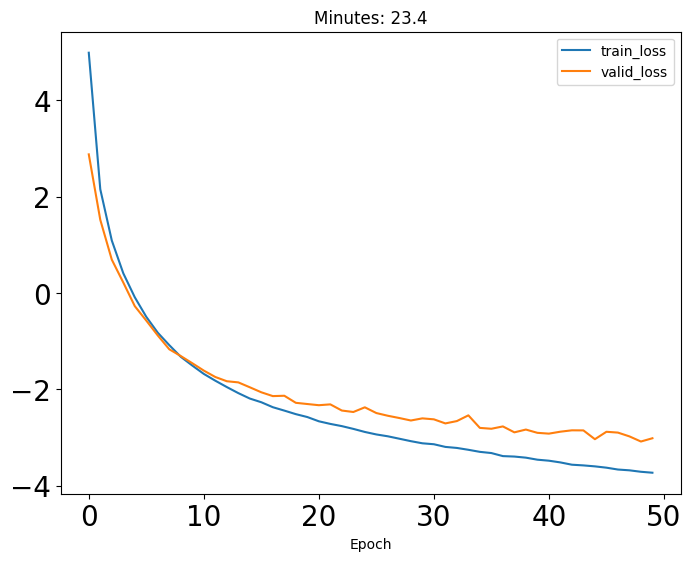

In [28]:
# loss evaluation
%matplotlib inline
train_loss = np.load(path_cinn_model_save + "50ep/"  + 'train_loss.npy')
valid_loss = np.load(path_cinn_model_save + "50ep/"  +'test_loss.npy')
trainvalid_loss = np.concatenate([train_loss.reshape([train_loss.shape[0], 1]), 
									  valid_loss.reshape([valid_loss.shape[0], 1])], axis = 1)
trainvalid_loss_pd = pd.DataFrame(trainvalid_loss)
trainvalid_loss_pd.columns = ['train_loss', 'valid_loss']
trainvalid_loss_pd['Epoch'] = list(range(trainvalid_loss_pd.shape[0]))
train_time = np.load(path_cinn_model_save + "50ep/" + 'training_time.npy')
train_time = round(train_time/60.0, 1)
newfig = trainvalid_loss_pd.set_index('Epoch').plot(figsize = [8,6 ], fontsize = 20).get_figure()
plt.title("Minutes: " + str(train_time))

**Load the cinn**

In [ ]:
path_cinn_model_save = "./lincs_example/cinn/"
torch.manual_seed(42)
flow_model_lincs = ConditionalFlatCouplingFlow(   conditioning_dim = 196, # dimension of your perturbation embeddings
                                            embedding_dim = 10, # dimension of your cell states embeddings
                                            conditioning_depth = 2, 
                                            n_flows = 20, # number of flow blocks
                                            in_channels = 10, 
                                            hidden_dim = 1024, 
                                            hidden_depth = 2, 
                                            activation = "none", 
                                            conditioner_use_bn = True)

model_c_lincs = Net2NetFlow_TFVAEFlow(  configured_flow = flow_model_lincs,
                                        first_stage_data = lincs_train,
                                        cond_stage_data = cond_stage_data_lincs,
                                        perturbToOnehotLib = perturbToEmbed_lincs,
                                        oneHotData = embeddings_lincs, 
                                        model_con = model_chemvae, 
                                        std_model = std_model, 
                                        sess = vae.sess, 
                                        enc_ph = vae.x, 
                                        z_gen_data_v = vae.z_mean, 
                                        is_training = vae.is_training)

model_c_lincs.load(path_cinn_model_save + "50ep/")
model_c_lincs.to(device = device)

**Note: To use PerturbNet with Python 3.10, you should build your Cinn as follows:**

In [ ]:
model_c_lincs = Net2NetFlow_TFVAEFlow(  configured_flow = flow_model_lincs,
                                        first_stage_data = lincs_train,
                                        cond_stage_data = cond_stage_data_lincs,
                                        perturbToOnehotLib = perturbToEmbed_lincs,
                                        oneHotData = embeddings_lincs, 
                                        model_con = model_chemvae, 
                                        std_model = std_model, 
                                        model_cell = vae)

# Adjusted cinn on sciplex
we change the conditioning_dim from 196 to 200 because we add cell type and doseage as the covariates.

In [15]:
cell_type = pd.get_dummies(adata_train_sciplex.obs["cell_type"])[['A549', 'K562', 'MCF7']].to_numpy()
dose= adata_train_sciplex.obs[["dose"]].to_numpy()
covariates_embedding = np.concatenate([cell_type,dose],axis=1)

In [16]:
covariates_embedding.shape

(25000, 4)

In [60]:
path_cinn_model_save = "./sciplex_example/cinn/"
torch.manual_seed(42)
flow_model_sciplex= ConditionalFlatCouplingFlow(
                                            conditioning_dim = 200, 
                                            embedding_dim = 10, 
                                            conditioning_depth = 2, 
                                            n_flows = 20, 
                                            in_channels = 10, 
                                            hidden_dim = 1024, 
                                            hidden_depth = 2, 
                                            activation = "none", 
                                            conditioner_use_bn = True)

model_c_sciplex = Net2NetFlow_TFVAE_Covariate_Flow(
                                     configured_flow = flow_model_sciplex,
                                    first_stage_data = adata_train_sciplex.X.A,
                                    cond_stage_data = cond_stage_data_sciplex,
                                    perturbToOnehotLib = perturbToEmbed_sciplex,
                                    oneHotData = embeddings_sciplex, 
                                    model_con = model_chemvae, 
                                    std_model = std_model, 
                                    covariates = covariates_embedding,
                                    scvi_model = scvi_model)
model_c_sciplex.to(device = device)
model_c_sciplex.train_cinn(n_epochs = 25, batch_size = 128, lr = 4.5e-6, auto_save = 10,auto_save_path = path_cinn_model_save + "Auto/")
model_c_sciplex.save(path_cinn_model_save + "25ep/")

Note: Conditioning network uses batch-normalization. Make sure to train with a sufficiently large batch size
[Epoch 1/25] [Batch 40/40] [loss: 4.247905/3.969820]
[Epoch 2/25] [Batch 40/40] [loss: 3.974565/3.859042]
[Epoch 3/25] [Batch 40/40] [loss: 3.817195/3.741591]
[Epoch 4/25] [Batch 40/40] [loss: 3.613688/3.562592]
[Epoch 5/25] [Batch 40/40] [loss: 3.487485/3.447937]
[Epoch 6/25] [Batch 40/40] [loss: 3.377574/3.357573]
[Epoch 7/25] [Batch 40/40] [loss: 3.315971/3.328976]
[Epoch 8/25] [Batch 40/40] [loss: 3.250670/3.278213]
[Epoch 9/25] [Batch 40/40] [loss: 3.211307/3.239922]
[Epoch 10/25] [Batch 40/40] [loss: 3.169125/3.236162]
[Epoch 11/25] [Batch 40/40] [loss: 3.141174/3.210063]
[Epoch 12/25] [Batch 40/40] [loss: 3.095528/3.238168]
[Epoch 13/25] [Batch 40/40] [loss: 3.068778/3.195604]
[Epoch 14/25] [Batch 40/40] [loss: 3.049774/3.142782]
[Epoch 15/25] [Batch 40/40] [loss: 3.010805/3.143708]
[Epoch 16/25] [Batch 40/40] [loss: 2.989883/3.142794]
[Epoch 17/25] [Batch 40/40] [loss: 2

Text(0.5, 1.0, 'Minutes: 8.6')

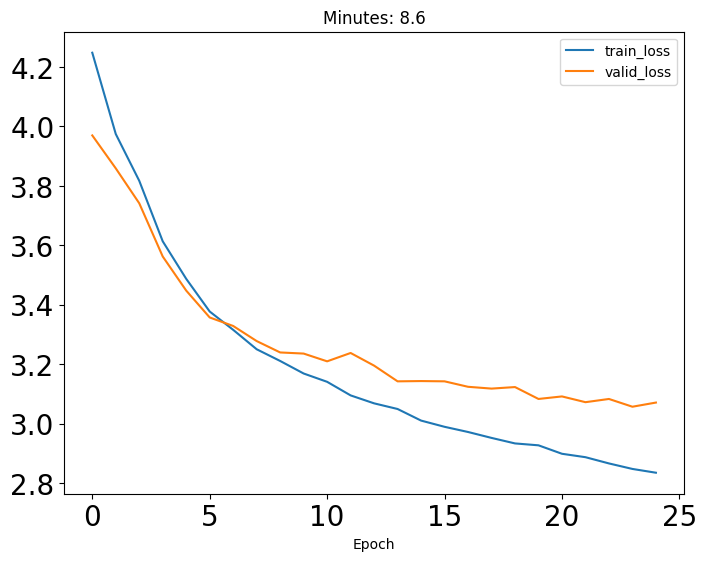

In [61]:
# loss evaluation
%matplotlib inline
train_loss = np.load(path_cinn_model_save + "25ep/"  + 'train_loss.npy')
valid_loss = np.load(path_cinn_model_save + "25ep/"  +'test_loss.npy')
trainvalid_loss = np.concatenate([train_loss.reshape([train_loss.shape[0], 1]), 
									  valid_loss.reshape([valid_loss.shape[0], 1])], axis = 1)
trainvalid_loss_pd = pd.DataFrame(trainvalid_loss)
trainvalid_loss_pd.columns = ['train_loss', 'valid_loss']
trainvalid_loss_pd['Epoch'] = list(range(trainvalid_loss_pd.shape[0]))
train_time = np.load(path_cinn_model_save + "25ep/" + 'training_time.npy')
train_time = round(train_time/60.0, 1)
newfig = trainvalid_loss_pd.set_index('Epoch').plot(figsize = [8,6 ], fontsize = 20).get_figure()
plt.title("Minutes: " + str(train_time))

**Load the cinn**

In [ ]:
path_cinn_model_save = "./sciplex_example/cinn/25ep/"
torch.manual_seed(42)
flow_model_sciplex= ConditionalFlatCouplingFlow(   conditioning_dim = 200, # dimension of your perturbation embeddings
                                            embedding_dim = 10, # dimension of your cell states embeddings
                                            conditioning_depth = 2, 
                                            n_flows = 20, # number of flow blocks
                                            in_channels = 10, 
                                            hidden_dim = 1024, 
                                            hidden_depth = 2, 
                                            activation = "none", 
                                            conditioner_use_bn = True)

model_c_sciplex = Net2NetFlow_TFVAE_Covariate_Flow(
                                     configured_flow = flow_model_sciplex,
                                    first_stage_data = adata_train_sciplex.X.A,
                                    cond_stage_data = cond_stage_data_sciplex,
                                    perturbToOnehotLib = perturbToEmbed_sciplex,
                                    oneHotData = embeddings_sciplex, 
                                    model_con = model_chemvae, 
                                    std_model = std_model, 
                                    covariates = covariates_embedding,
                                    scvi_model = scvi_model)
model_c_sciplex.load(path_cinn_model_save)
model_c_sciplex.to(device = device)

# Inference - unadjusted model with regular VAE

**Extract ground truth cell embeddings for the test data**  
Zsample_test is the latent cell embeddings for cells in the test set, estimated by regular VAE

In [19]:
Zsample_test = vae.encode(lincs_test)

**Construct PerturbNet**  

In [30]:
model_c_lincs.eval()
perturbnet_model = TFVAEZ_CheckNet2Net(model_c_lincs, device, vae.sess, vae.x_hat, vae.z_mean, vae.is_training)

**Predict unseen perturbation**  
1. Create the one-hot matrix for the unseen perturbation and replicate it to match the desired number of cells.
2. Use the ChemicalVAE  to convert the one-hot matrix into the perturbation representation.
3. Use std model to standardize the perturbation representation
4. Predict a distribution of cells under the target unseen perturbation.  


In [77]:

unseen_pert = "O=C(NC1=C(N2CCN(CC2)c2ccccc2)C(=O)c2ccccc2C1=O)c1ccccc1"
pert_idx = np.where(adata_test_lincs.uns["ordered_all_smile"] == unseen_pert)[0][0]
unseen_pert_embed = adata_test_lincs.uns["ordered_all_onehot"][pert_idx]

In [80]:
n_cells = 770
trt_input_onehot = np.tile(unseen_pert_embed, (n_cells, 1, 1))
_, _, _, embdata_torch = model_c_lincs.model_con(torch.tensor(trt_input_onehot).float().to(device))
pert_embed = std_model.standardize_z(embdata_torch.cpu().detach().numpy())
predict_latent, predict_data = perturbnet_model.sample_data(pert_embed)

predict_latent is the predicted cell representation;  
predict_data represents the predicted gene expressions;  
pert_embed is the standardized perturbation representation.

In [41]:
real_latent = Zsample_test[np.where(adata_test_lincs.obs.perturb_string  == unseen_pert)[0]]
real_latent.shape

(770, 10)

In [47]:
real_data = adata_test_lincs.X[np.where(adata_test_lincs.obs.perturb_string  == unseen_pert)[0]]
real_data.shape

(770, 978)

**Sanity check if the predicted cell embeddings mixed well with the real cell embeddings**

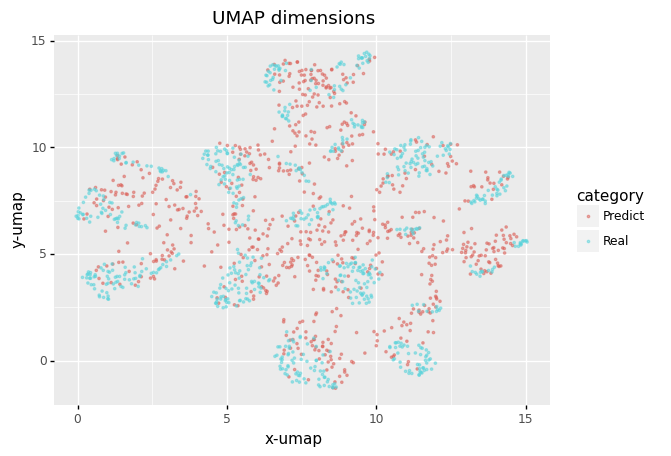

<ggplot: (1418882157965)>

In [43]:
all_latent = np.concatenate([predict_latent, real_latent], axis = 0)
cat_t = ["Real"] * real_latent.shape[0]
cat_g = ["Predict"] * predict_latent.shape[0]
cat_rf_gt = np.append(cat_g, cat_t)
trans = umap.UMAP(random_state=42, min_dist = 0.5, n_neighbors=30).fit(all_latent)
X_embedded_pr = trans.transform(all_latent)
df = X_embedded_pr.copy()
df = pd.DataFrame(df)
df['x-umap'] = X_embedded_pr[:,0]
df['y-umap'] = X_embedded_pr[:,1]
df['category'] = cat_rf_gt
    
chart_pr = ggplot(df, aes(x= 'x-umap', y= 'y-umap', colour = 'category') ) \
    + geom_point(size=0.5, alpha = 0.5) \
    + ggtitle("UMAP dimensions")
chart_pr

**Calculate the rsquare value for the normalized data**

In [48]:
fidscore_cal = fidscore()
r2_value = fidscore_cal.calculate_r_square(real_data, predict_data)
r2_value

0.9738071911217121

**Visualize the mapping from the perturbation representation to the cellular representation**
1. We need to generate background embeddings for perturbations and cells, excluding the specific perturbation we want to highlight.
2. Use ```contourplot_space_mapping``` to display the mapping relationships. Ensure you specify enough colors for the highlighted perturbations

In [45]:
drug1 = "COCC1OC(=O)c2coc3c2C1(C)C1=C(C2CCC(=O)C2(C)CC1OC(C)=O)C3=O"
drug2 = "ONC(=O)CCCCCCC(=O)Nc1ccccc1"

In [46]:
unseen_pert_embed_drug1 =  adata_train_lincs.uns["ordered_all_onehot"][np.where(adata_train_lincs.uns["ordered_all_smile"] == drug1)[0] ]
unseen_pert_embed_drug2 = adata_train_lincs.uns["ordered_all_onehot"][np.where(adata_train_lincs.uns["ordered_all_smile"] == drug2)[0] ]

In [57]:
n_cells = 30
trt_input_onehot_drug1 = np.tile(unseen_pert_embed_drug1, (n_cells, 1, 1))
_, _, _, embdata_torch_drug1 = model_c_lincs.model_con(torch.tensor(trt_input_onehot_drug1).float().to(device))
pert_embed1 = std_model.standardize_z(embdata_torch_drug1.cpu().detach().numpy())
predict_latent_1, predict_data_1 = perturbnet_model.sample_data(pert_embed1)

In [58]:
n_cells = 30
trt_input_onehot_drug2 = np.tile(unseen_pert_embed_drug2, (n_cells, 1, 1))
_, _, _, embdata_torch_drug2 = model_c_lincs.model_con(torch.tensor(trt_input_onehot_drug2).float().to(device))
pert_embed2 = std_model.standardize_z(embdata_torch_drug2.cpu().detach().numpy())
predict_latent_2, predict_data_2 = perturbnet_model.sample_data(pert_embed2)

In [59]:
predict_latent = np.concatenate([predict_latent_1,predict_latent_2],axis = 0)
pert_embed = np.concatenate([pert_embed1,pert_embed2 ],axis = 0)

In [55]:
background_pert = []
background_cell = []
n_cells_bk = 1
highlights = [drug1, drug2]
for i in tqdm(range(len(adata_train_lincs.uns["ordered_all_smile"]))):
    pert = adata_train_lincs.uns["ordered_all_smile"][i]
    if pert in highlights:
        continue
    pert_embed_tmp = adata_train_lincs.uns["ordered_all_onehot"][i]
    trt_input_fixed_bk = np.tile(pert_embed_tmp, (n_cells_bk, 1,1))
    _, _, _, embdata_torch_bk = model_c_lincs.model_con(torch.tensor(trt_input_fixed_bk).float().to(device))
    pert_embed_bk = std_model.standardize_z(embdata_torch_bk.cpu().detach().numpy())
    predict_latent_bk, predict_data_bk = perturbnet_model.sample_data(pert_embed_bk)
    
    background_pert.append(pert_embed_bk )
    background_cell.append(predict_latent_bk)
    
background_pert = np.concatenate(background_pert)
background_cell = np.concatenate(background_cell)
    

100%|██████████| 19990/19990 [05:56<00:00, 56.12it/s]


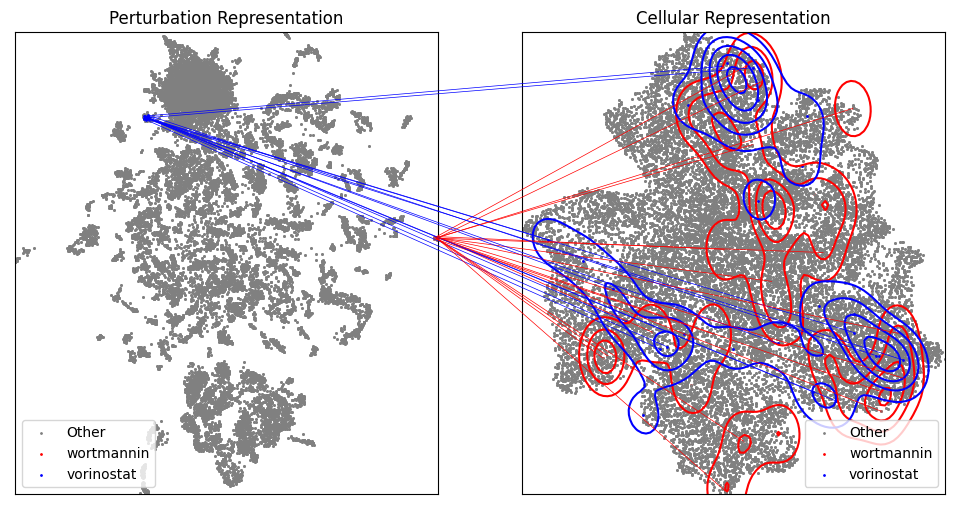

In [60]:
%matplotlib inline
contourplot_space_mapping(predict_latent, pert_embed, background_pert, background_cell, highlight_labels =  ["wortmannin","vorinostat"], colors = ["red", "blue"])

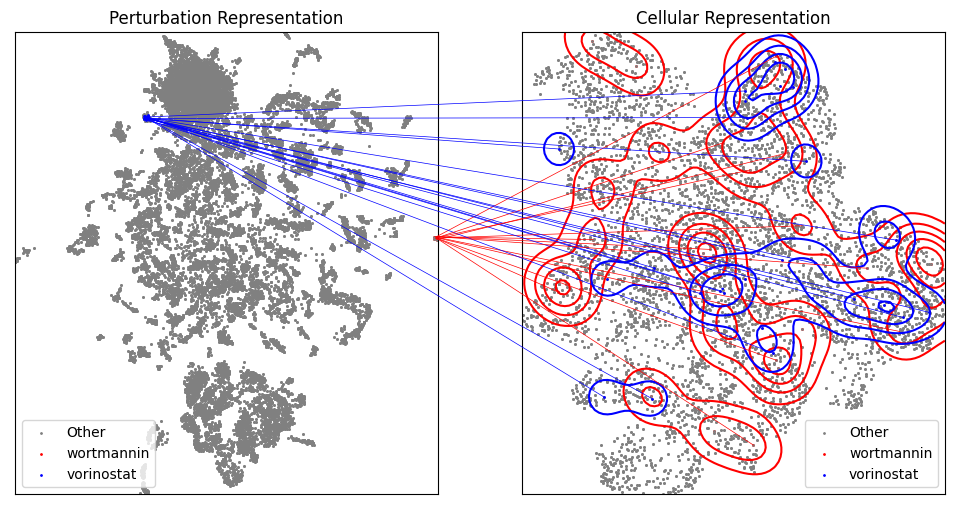

In [61]:
# relative down sample the background cell latent to make the distribution more clear
background_cell_down = background_cell[0:5000]
contourplot_space_mapping(predict_latent, pert_embed, background_pert, background_cell_down , highlight_labels =  ["wortmannin","vorinostat"], colors = ["red", "blue"])

# Inference - adjusted model with scVI

**Extract ground truth cell embeddings for the test data**  
Zsample_test is the latent cell embeddings for cells in the test set, estimated by scvi

In [71]:
scvi.data.setup_anndata(adata_test_sciplex, layer = "counts")
Zsample_test = scvi_model.get_latent_representation(adata = adata_test_sciplex, give_mean = False)

INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.layers["counts"]                                                                    
INFO     Computing library size prior per batch                                                                    
INFO     Successfully registered anndata object containing 6200 cells, 5087 vars, 1 batches, 1 labels, and 0       
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                


**Construct PerturbNet**  
scvi requires library size to make inference, so we sample the library size from observed data(Lsample_obs)

In [64]:
model_c_sciplex.eval()
scvi_model_de = scvi_predictive_z(scvi_model)
perturbnet_model = SCVIZ_CheckNet2Net(model_c_sciplex, device, scvi_model_de)
Lsample_obs = scvi_model.get_latent_library_size(adata = adata_train_sciplex, give_mean = False)

**Predict unseen perturbation**  
1. Create the one-hot matrix for the unseen perturbation and replicate it to match the desired number of cells.
2. Use the ChemicalVAE to convert the one-hot matrix into the perturbation representation.
3. Concatenate the corvariates to the perturbation representatio
4. Sample the library size from the observed data.
5. Predict a distribution of cells under the target unseen perturbation.  


In [65]:
unseen_pert = "COc1ccc(Cn2ccc3ccc(C(=O)NO)cc32)cc1"
pert_idx = np.where(adata_test_sciplex.uns["ordered_all_smile_chemvae"] == unseen_pert)[0][0]
unseen_pert_embed = adata_test_sciplex.uns["ordered_all_onehot_chemvae"][pert_idx]

predict_latent is the predicted cell representation;  
predict_data represents the predicted gene expressions;  
embdata_np is the standardized perturbation representation;  
pert_embed represents the combined perturbation and covariate information.

In [66]:
cell_type_test = pd.get_dummies(adata_test_sciplex.obs["cell_type"])[['A549', 'K562', 'MCF7']].to_numpy()
dose_test = adata_test_sciplex.obs[["dose"]].to_numpy()
covariates_embedding_test = np.concatenate([cell_type_test,dose_test],axis=1)

In [68]:
covariates_embedding_target = covariates_embedding_test[np.where(adata_test_sciplex.obs.perturb_string  == unseen_pert)[0]]

In [102]:
covariates_embedding_target.shape

(200, 4)

In [96]:
n_cells = 200
trt_input_onehot = np.tile(unseen_pert_embed, (n_cells, 1, 1))
_, _, _, embdata_torch = model_c_sciplex.model_con(torch.tensor(trt_input_onehot).float().to(device))
embdata_np = std_model.standardize_z(embdata_torch.cpu().detach().numpy())
pert_embed = np.concatenate([embdata_np,covariates_embedding_target],axis = 1)
Lsample_idx = np.random.choice(range(Lsample_obs.shape[0]), n_cells, replace=True)
library_trt_latent =Lsample_obs[Lsample_idx]
predict_latent, predict_data = perturbnet_model.sample_data(pert_embed, library_trt_latent)

In [72]:
real_latent = Zsample_test[np.where(adata_test_sciplex.obs.perturb_string  == unseen_pert)[0]]
real_latent.shape

(200, 10)

In [73]:
real_data = adata_test_sciplex.layers["counts"].A[np.where(adata_test_sciplex.obs.perturb_string  == unseen_pert)[0]]
real_data.shape

(200, 5087)

**Sanity check if the predicted cell embeddings mixed well with the real cell embeddings**

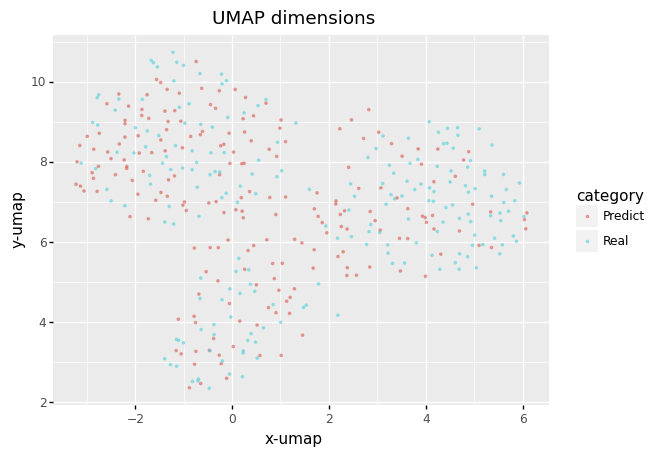

<ggplot: (1447351468725)>

In [74]:
all_latent = np.concatenate([predict_latent, real_latent], axis = 0)
cat_t = ["Real"] * real_latent.shape[0]
cat_g = ["Predict"] * predict_latent.shape[0]
cat_rf_gt = np.append(cat_g, cat_t)
trans = umap.UMAP(random_state=42, min_dist = 0.5, n_neighbors=30).fit(all_latent)
X_embedded_pr = trans.transform(all_latent)
df = X_embedded_pr.copy()
df = pd.DataFrame(df)
df['x-umap'] = X_embedded_pr[:,0]
df['y-umap'] = X_embedded_pr[:,1]
df['category'] = cat_rf_gt
    
chart_pr = ggplot(df, aes(x= 'x-umap', y= 'y-umap', colour = 'category') ) \
    + geom_point(size=0.5, alpha = 0.5) \
    + ggtitle("UMAP dimensions")
chart_pr

**Calculate the rsquare value**

In [107]:
normModel = NormalizedRevisionRSquare(largeCountData = adata_test_sciplex.layers["counts"].A)

In [108]:
r2_value, _, _ = normModel.calculate_r_square(real_data, predict_data)
r2_value

0.8984451516862797

**Visualize the mapping from the perturbation representation to the cellular representation**
1. We need to generate background embeddings for perturbations and cells, excluding the specific perturbation we want to highlight.
2. Use ```contourplot_space_mapping``` to display the mapping relationships. Ensure you specify enough colors for the highlighted perturbations

In [113]:
background_pert = []
background_cell = []
highlights = [unseen_pert]
for pert in tqdm(adata_test_sciplex.obs.perturb_string_processed.unique()):
    if pert in highlights:
        continue
    covariates_embedding_target_bk = covariates_embedding_test[np.where(adata_test_sciplex.obs.perturb_string_processed  == pert)[0]]
    n_cells_bk =  covariates_embedding_target_bk.shape[0]
    pert_idx_bk = np.where(adata_test_sciplex.uns["ordered_all_smile_chemvae"] == pert)[0][0]
    
    pert_embed_tmp = adata_train_sciplex.uns["ordered_all_onehot_chemvae"][pert_idx_bk]
    Lsample_idx = np.random.choice(range(Lsample_obs.shape[0]), n_cells, replace=True)
    trt_input_fixed_bk = np.tile(pert_embed_tmp, (n_cells_bk, 1, 1))
    _, _, _, embdata_torch_bk =  model_c_sciplex.model_con(torch.tensor(trt_input_fixed_bk).float().to(device))
    embdata_np_bk = std_model.standardize_z(embdata_torch_bk.cpu().detach().numpy())
   
    pert_embed_bk = np.concatenate([embdata_np_bk,covariates_embedding_target_bk],axis = 1)
    
    library_trt_latent = Lsample_obs[Lsample_idx]
    predict_latent_bk, predict_data_bk = perturbnet_model.sample_data(pert_embed_bk, library_trt_latent)
    
    background_pert.append( embdata_np_bk)
    background_cell.append(predict_latent_bk)
    
background_pert = np.concatenate(background_pert)
background_cell = np.concatenate(background_cell)
    

100%|██████████| 31/31 [00:05<00:00,  6.18it/s]


/home/wzqian/.local/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.


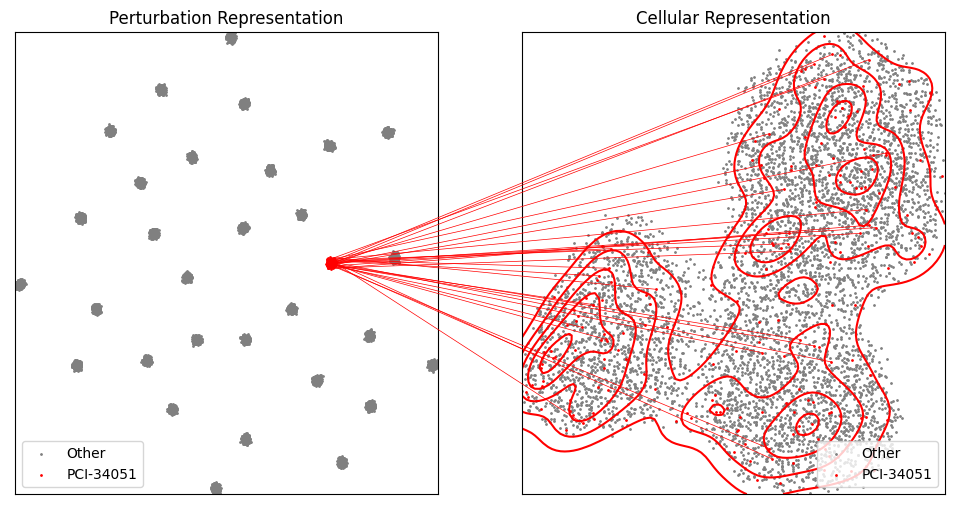

In [114]:
# Note that the perturbation space does not account for covariates.
contourplot_space_mapping(predict_latent, embdata_np, background_pert, background_cell,
                          highlight_labels =  ["PCI-34051"], colors = ["red"])